<a href="https://colab.research.google.com/github/Akash-sahay/Deep-Learning-for-Medicine/blob/main/Covid_19_Detection_from_X_ray_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import cv2
import seaborn as sns
import tensorflow as tf
# Import ImageDataGenerator directly from tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [4]:
import zipfile
import os

# Specify the correct path to the zip file if it's not in the current directory
zip_file_path = '/content/archive (1).zip'  # Replace with the actual path

# Check if the file exists
if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('dataset')
else:
    print(f"Error: File not found at {zip_file_path}")

In [5]:
os.listdir('dataset')

['dataset']

In [31]:
dir = '/content/dataset/dataset'
dir_train = f'{dir}/train'
dir_valid = f'{dir}/validation'

In [17]:
dir_train

'/content/dataset/dataset/train'

In [33]:
# Data augmentation for training and rescaling for test
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,  # Rotate images randomly
    zoom_range=0.2,  # Zoom in randomly
    horizontal_flip=True  # Flip images horizontally
)
test_datagen = ImageDataGenerator(rescale=1./255)  # Only normalize for test
# Load images from directories
train_generator = train_datagen.flow_from_directory(
    dir_train,
    target_size=(224, 224),  # Resize images
    batch_size=32,
    class_mode='categorical',  # For multi-class classification
    shuffle=True  # Shuffle data
)
test_generator = test_datagen.flow_from_directory(
    dir_valid,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7367 images belonging to 3 classes.
Found 1841 images belonging to 3 classes.


In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: Normal, COVID, Pneumonia
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator
)

Epoch 1/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 98s 412ms/step - accuracy: 0.8821 - loss: 0.3140 - val_accuracy: 0.8017 - val_loss: 0.4142
Epoch 2/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 97s 408ms/step - accuracy: 0.8907 - loss: 0.2946 - val_accuracy: 0.8229 - val_loss: 0.4313
Epoch 3/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 143s 411ms/step - accuracy: 0.9002 - loss: 0.2692 - val_accuracy: 0.9093 - val_loss: 0.2543
Epoch 4/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 98s 414ms/step - accuracy: 0.9142 - loss: 0.2435 - val_accuracy: 0.8729 - val_loss: 0.3716
Epoch 5/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 143s 413ms/step - accuracy: 0.9139 - loss: 0.2575 - val_accuracy: 0.8408 - val_loss: 0.3715


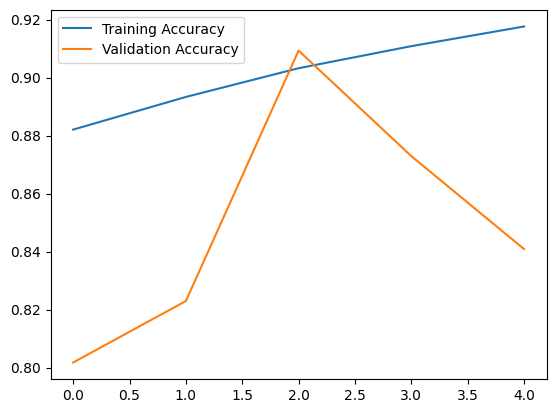

58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.8497 - loss: 0.3532
Test Accuracy: 0.84


In [39]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy:.2f}')

In [40]:
model.save('model.h5')


In [41]:
!pip install flask-ngrok


In [42]:
from flask import Flask, request, render_template
from flask_ngrok import run_with_ngrok
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

# Initialize Flask app
app = Flask(__name__)
run_with_ngrok(app)

# Load the saved model
model = tf.keras.models.load_model('model.h5')

# Define classes
CLASSES = ['Normal', 'Covid-19', 'Pneumonia']

# Define the home route
@app.route('/')
def home():
    return '''
    <h1>Covid-19 Detection from X-ray</h1>
    <form action="/predict" method="post" enctype="multipart/form-data">
        <input type="file" name="file" />
        <input type="submit" value="Predict" />
    </form>
    '''

# Define the prediction route
@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return 'No file uploaded'

    file = request.files['file']
    file_path = f"temp/{file.filename}"

    # Save uploaded file temporarily
    if not os.path.exists('temp'):
        os.makedirs('temp')
    file.save(file_path)

    # Preprocess the image
    img = load_img(file_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = CLASSES[np.argmax(predictions)]

    # Remove the temp file
    os.remove(file_path)

    return f'Predicted class: {predicted_class}'

# Run the app
app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-37:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 199, in _new_conn
    sock = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 789, in urlopen
    response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urll